In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from sklearn.model_selection import cross_val_score, learning_curve, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time
from torch.utils.data import Subset

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_indices = list(range(10000)) 
test_indices = list(range(2000))  

train_subset = Subset(trainset, train_indices)
test_subset = Subset(testset, test_indices)

batch_size = 4
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=2)

full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
full_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)
full_trainloader = torch.utils.data.DataLoader(full_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
full_testloader = torch.utils.data.DataLoader(full_testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [7]:
def convert_to_numpy(dataloader):
    data, labels = [], []
    for i, j in dataloader:
        data.append(i.view(i.size(0), -1).numpy())
        labels.append(j.numpy())
    data = np.concatenate(data)
    labels = np.concatenate(labels)
    return data, labels

X_train, y_train = convert_to_numpy(trainloader)
X_test, y_test = convert_to_numpy(testloader)

X_full_train, y_full_train = convert_to_numpy(full_trainloader)
X_full_test, y_full_test = convert_to_numpy(full_testloader)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_full_train = scaler.fit_transform(X_full_train)
X_full_test = scaler.transform(X_full_test)

In [8]:
C_values = [0.01, 0.1, 1, 10, 100]
C_accuracies = {}

# 5-fold cross-validation
for C in C_values:
    lr = LogisticRegression(C=C, max_iter=5000, random_state=seed)
    accuracies = cross_val_score(lr, X_train, y_train, cv=5)
    C_accuracies[C] = accuracies
    for i in accuracies:
        print(f"C = {C}, accuracy = {i:.4f}")

C = 0.01, accuracy = 0.3545
C = 0.01, accuracy = 0.3565
C = 0.01, accuracy = 0.3675
C = 0.01, accuracy = 0.3475
C = 0.01, accuracy = 0.3510
C = 0.1, accuracy = 0.3150
C = 0.1, accuracy = 0.3055
C = 0.1, accuracy = 0.3115
C = 0.1, accuracy = 0.3000
C = 0.1, accuracy = 0.3105
C = 1, accuracy = 0.2835
C = 1, accuracy = 0.2695
C = 1, accuracy = 0.2800
C = 1, accuracy = 0.2655
C = 1, accuracy = 0.2835
C = 10, accuracy = 0.2630
C = 10, accuracy = 0.2480
C = 10, accuracy = 0.2580
C = 10, accuracy = 0.2430
C = 10, accuracy = 0.2615
C = 100, accuracy = 0.2640
C = 100, accuracy = 0.2455
C = 100, accuracy = 0.2550
C = 100, accuracy = 0.2425
C = 100, accuracy = 0.2520


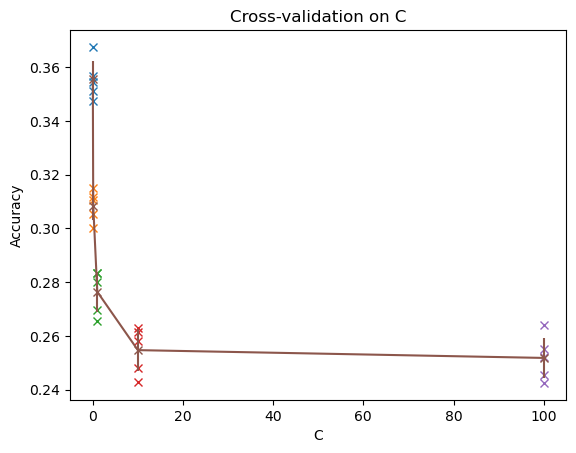

In [9]:
for C in C_values:
    plt.plot([C] * len(C_accuracies[C]), C_accuracies[C], 'x')

mean_accuracies = [np.mean(C_accuracies[C]) for C in C_accuracies]
std_accuracies = [np.std(C_accuracies[C]) for C in C_accuracies]

plt.errorbar(C_values, mean_accuracies, yerr=std_accuracies, fmt='-x')
plt.title('Cross-validation on C')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.show()

In [10]:
best_C_value = C_values[np.argmax([np.mean(v) for C, v in sorted(C_accuracies.items())])]
print(f"Best C based on cross-validation: {best_C_value}")

Best C based on cross-validation: 0.01


In [11]:
lr = LogisticRegression(C=best_C_value, max_iter=5000, random_state=seed)
lr.fit(X_train, y_train)

train_acc = accuracy_score(y_train, lr.predict(X_train))
test_acc = accuracy_score(y_test, lr.predict(X_test))

print(f"Best C value: {best_C_value}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

Best C value: 0.01, Train Accuracy: 0.5916, Test Accuracy: 0.3510


In [12]:
train_sizes = [50, 500, 2000, 5000, 10000, 20000, 40000]

def errors_for_train_sizes_lr(X_tr, y_tr, X_te, y_te, seed, train_sizes, best_C):
    tr_err_lr = [] 
    te_err_lr = [] 

    for i in train_sizes:
        lr = LogisticRegression(C=best_C, max_iter=5000, random_state=seed)
        lr.fit(X_tr[:i], y_tr[:i])

        train_predictions = lr.predict(X_tr[:i])
        tr_err_lr.append(1 - np.mean(train_predictions == y_tr[:i]))

        test_predictions = lr.predict(X_te)
        te_err_lr.append(1 - np.mean(test_predictions == y_te))

    return tr_err_lr, te_err_lr

In [13]:
def plot_errors_for_train_sizes_lr(train_sizes, tr_err_lr, te_err_lr):
    plt.semilogx(train_sizes, tr_err_lr, label='Train LR', marker='x', linestyle='-', color='blue')
    plt.semilogx(train_sizes, te_err_lr, label='Test LR', marker='x', linestyle='--', color='blue')

    plt.xlabel('Number of Training Data Points')
    plt.ylabel('Error Rate')
    plt.legend()
    plt.title('Learning Curve for Logistic Regression (Error)')
    plt.show()

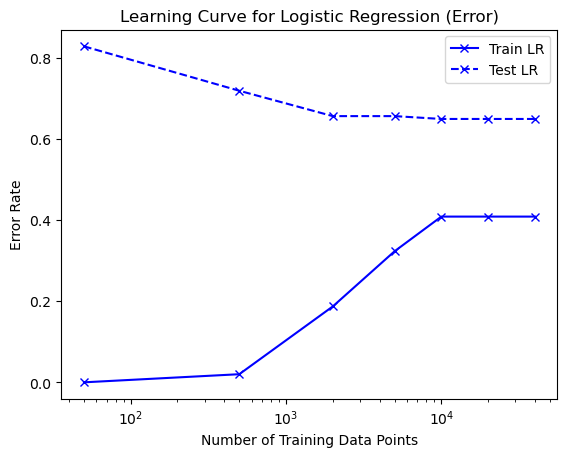

In [14]:
tr_err_lr, te_err_lr = errors_for_train_sizes_lr(X_train, y_train, X_test, y_test, seed, train_sizes, best_C_value)

plot_errors_for_train_sizes_lr(train_sizes, tr_err_lr, te_err_lr)

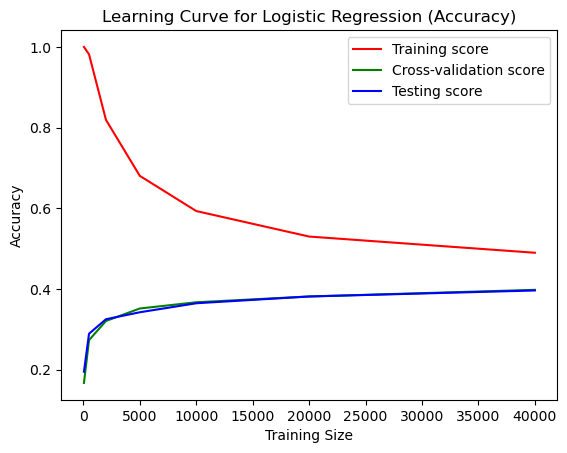

In [15]:
train_sizes_batch = [50, 500, 2000, 5000, 10000, 20000, 40000]

train_sizes_abs, train_scores, validation_scores = learning_curve(
    LogisticRegression(C=best_C_value, max_iter=5000, random_state=seed), X_full_train, y_full_train, cv=5, 
    train_sizes=train_sizes_batch, scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

testing_scores = []
for i in train_sizes_abs:
    X_train_sub, _, y_train_sub, _ = train_test_split(X_full_train, y_full_train, train_size=i/len(X_full_train), random_state=seed)
    lr = LogisticRegression(C=best_C_value, max_iter=5000, random_state=seed)
    lr.fit(X_train_sub, y_train_sub)
    testing_scores.append(accuracy_score(y_full_test, lr.predict(X_full_test)))

test_scores = np.array(testing_scores)

plt.plot(train_sizes_abs, train_scores_mean, color='r', label='Training score')
plt.plot(train_sizes_abs, validation_scores_mean, color='g', label='Cross-validation score')
plt.plot(train_sizes_abs, test_scores, color='b', label='Testing score')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for Logistic Regression (Accuracy)')
plt.legend()
plt.show()

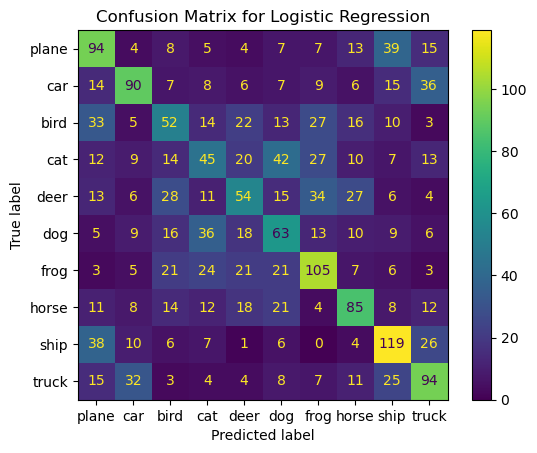

In [16]:
y_prediction = lr.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_prediction)
display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=classes)
display.plot()
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

In [17]:
start = time.time()
predictions = lr.predict(X_test)
end = time.time()
prediction_time = end - start
time_per_image = prediction_time / len(X_test)
print(f"Average prediction time per image: {time_per_image:.6f} seconds")

Average prediction time per image: 0.000008 seconds
